In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set()

In [4]:
data = pd.read_pickle('../data.pkl.xz')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## Show distribution of columns by histograms

In [5]:
discrete_columns = ['season', 'holiday', 'workingday', 'weather']

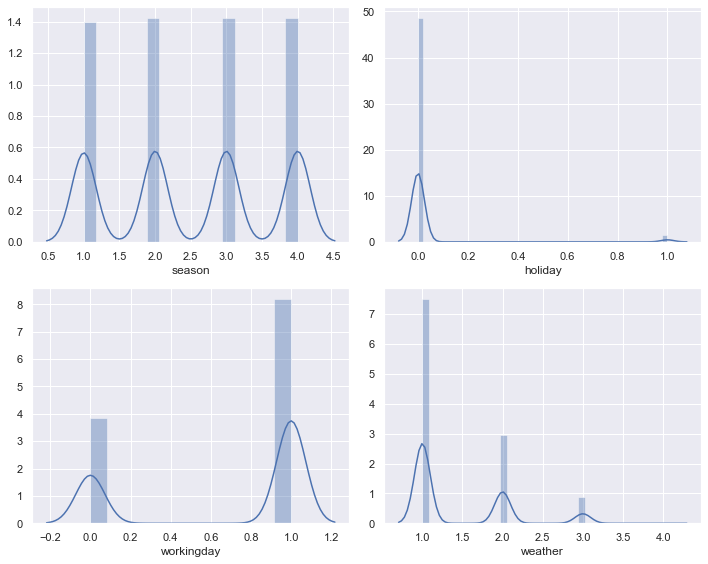

In [6]:
import math
graph_cols = 2
f, axes = plt.subplots(math.ceil(len(discrete_columns) / graph_cols), graph_cols, figsize=(10, 8))
for idx in range(len(discrete_columns)):
    ax = axes[int(idx / graph_cols), idx % graph_cols]
    ax.set_xlabel(discrete_columns[idx])
    sns.distplot(data[discrete_columns[idx]], ax=ax)
#     ax.hist(data[discrete_columns[idx]], density=False)

f.tight_layout()

In [7]:
data.groupby('weather').count()

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count
weather,,,,,,,,,,,
1,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192
2,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834
3,859,859,859,859,859,859,859,859,859,859,859
4,1,1,1,1,1,1,1,1,1,1,1


In [8]:
analog_columns = ['temp', 'atemp', 'windspeed', 'humidity', 'count', 'registered', 'casual']

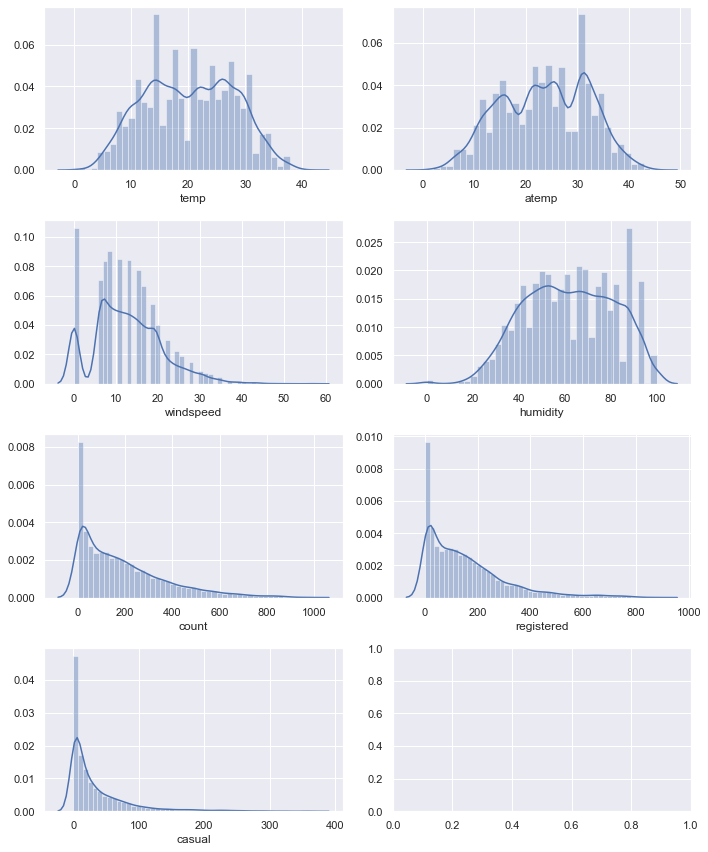

In [9]:
import math
graph_cols = 2
f, axes = plt.subplots(math.ceil(len(analog_columns) / graph_cols), graph_cols, figsize=(10, 12))
for idx in range(len(analog_columns)):
    ax = axes[int(idx / graph_cols), idx % graph_cols]
    ax.set_xlabel(analog_columns[idx])
#     ax.hist(data[analog_columns[idx]], edgecolor="black",linewidth=2,color='#ff4125', density=True)
    sns.distplot(data[analog_columns[idx]], ax=ax)

f.tight_layout()

## Count, registered and casual do not follow normal distribution

preprocess with some non-linear transformations

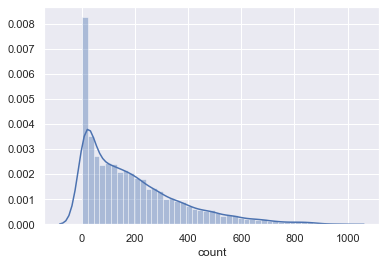

In [10]:
sns.distplot(data['count'])

### Use log transformation

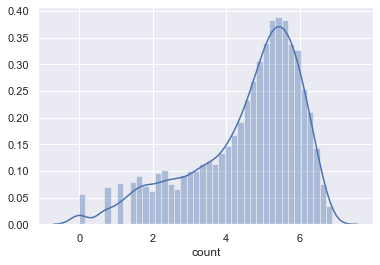

In [11]:
sns.distplot(np.log(data['count']))

### Use box-cox transformation (determine $\lambda$ by maximum likelihood estimation) 

In [12]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox', standardize=False)
pt.fit(data['count'].to_numpy().reshape(-1, 1))
print(pt)

PowerTransformer(copy=True, method='box-cox', standardize=False)


In [13]:
pt.lambdas_

array([0.31567024])

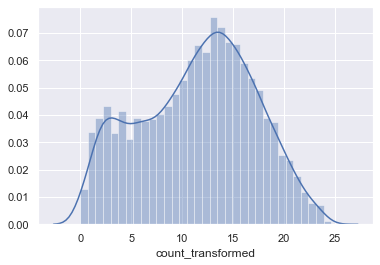

In [14]:
data['count_transformed'] = pt.transform(data['count'].to_numpy().reshape(-1, 1))
sns.distplot(data['count_transformed'])

In [15]:
np.isclose(
    pt.inverse_transform(
        data['count_transformed'].to_numpy().reshape(-1, 1)
    ).flatten(),
     data['count'].to_numpy()
).all()

True

### Use box-cox transformation (determine $\lambda$ with manual experiments) 

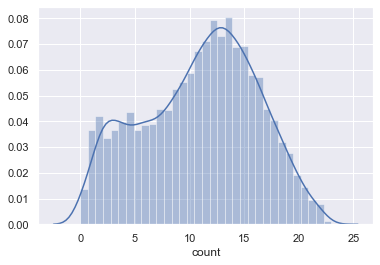

In [16]:
l = 0.3
sns.distplot((data['count'] ** l - 1) / l)

### Use q-q plot to validate if measurements follows a perticular distribution

http://en.wikipedia.org/wiki/Quantile-quantile_plot

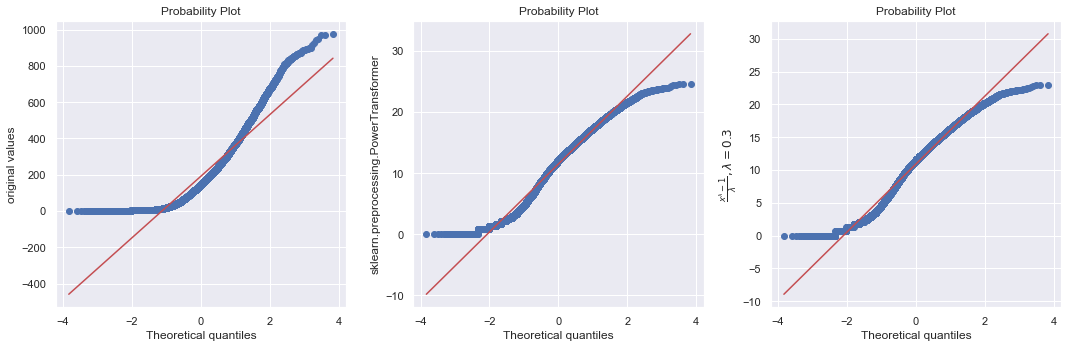

In [17]:
import scipy.stats as stats
f, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = stats.probplot(data['count'], dist="norm", plot=axes[0])
axes[0].set_ylabel('original values')
_ = stats.probplot(data['count_transformed'], dist="norm", plot=axes[1])
axes[1].set_ylabel('sklearn.preprocessing.PowerTransformer')
_ = stats.probplot((data['count'] ** l - 1) / l, dist="norm", plot=axes[2])
axes[2].set_ylabel(r'$\frac{x^\lambda - 1}{\lambda}, \lambda=%s$' % (l, ))
f.tight_layout()

## Discover outliers by boxplot

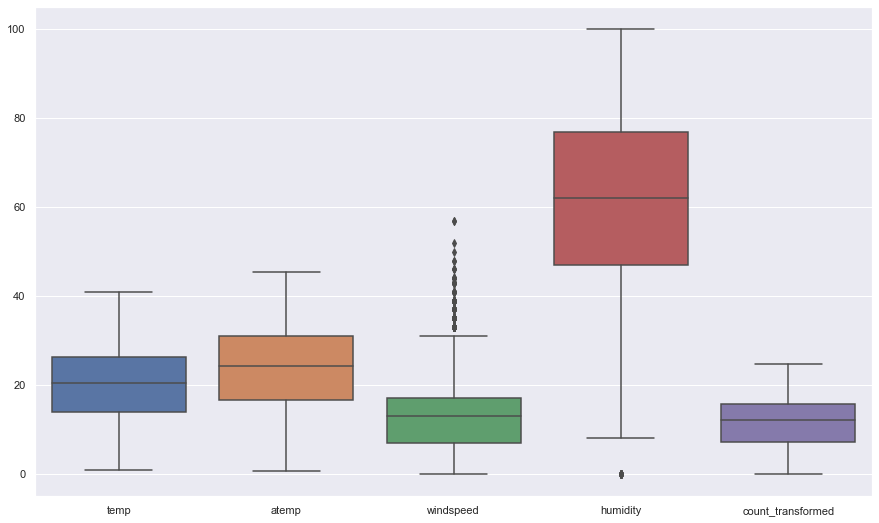

In [18]:
analog_columns = ['temp', 'atemp', 'windspeed', 'humidity', 'count_transformed']

sns.boxplot(
    data=data[analog_columns]
)
plt.gcf().set_size_inches(15,9)

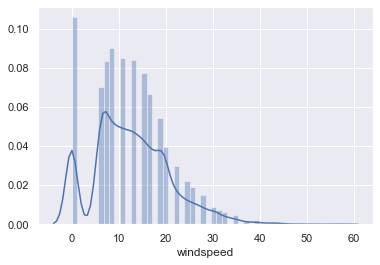

In [19]:
sns.distplot(data['windspeed'])

## Let's save the transformed data for training

In [20]:
data.to_pickle('../data-count-transformed.pkl.xz')

In [21]:
import pickle

with open('../count-power-transformer.pkl', 'wb') as outf:
    pickle.dump(pt, outf)